In [1]:
import subprocess as subp
from math import sqrt
from time import monotonic
from pathlib import Path
import os

# adjust this to your CRMC path 
crmc_path = "../../crmc/build"

crmc_path = Path(crmc_path)
assert crmc_path.exists()

timing = {}

models = ("EposLHC", "SIBYLL-2.3d", "QGSJet-II-04")
energies = [100, 1000, 10000, 100000]  # GeV

outfile = os.devnull
for model in models:
    model_code = {
        "EposLHC": "0",
        "SIBYLL-2.3d": "6",
        "QGSJet-II-04": "7",
    }[model]
    print("  ", model)
    times_crmc = []
    times_chromo = []
    for energy in energies:
        print("    ", energy)
        nevent = int(1e5 / sqrt(energy))
        if model == "SIBYLL-2.3d":
            nevent *= 10
        if model == "QGSJet-II-04":
            nevent *= 10
        t = monotonic()
        cmd = ["python", "-m", "chromo", "-s", "2", "-m", model_code, "-S", f"{energy}", "-n", f"{nevent}", "-o", "hepmc"]
        print("       ", " ".join(cmd))
        subp.run(cmd, stdin=subp.PIPE, stdout=subp.PIPE)
        times_chromo.append(nevent / (monotonic() - t))
        t = monotonic()
        cmd = ["bin/crmc", "-s", "2", "-m", model_code, "-S", f"{energy}", "-n", f"{nevent}", "-o", "hepmc", "-c", "etc/crmc.param"]
        print("       ", " ".join(cmd))
        subp.run(cmd, cwd=crmc_path, stdin=subp.PIPE, stdout=subp.PIPE)
        times_crmc.append(nevent / (monotonic() - t))
    timing[model] = (times_chromo, times_crmc)

   EposLHC
     100
        python -m chromo -s 2 -m 0 -S 100 -n 10000 -o hepmc
        bin/crmc -s 2 -m 0 -S 100 -n 10000 -o hepmc -c etc/crmc.param
     1000
        python -m chromo -s 2 -m 0 -S 1000 -n 3162 -o hepmc
        bin/crmc -s 2 -m 0 -S 1000 -n 3162 -o hepmc -c etc/crmc.param
     10000
        python -m chromo -s 2 -m 0 -S 10000 -n 1000 -o hepmc
        bin/crmc -s 2 -m 0 -S 10000 -n 1000 -o hepmc -c etc/crmc.param
     100000
        python -m chromo -s 2 -m 0 -S 100000 -n 316 -o hepmc
        bin/crmc -s 2 -m 0 -S 100000 -n 316 -o hepmc -c etc/crmc.param
   SIBYLL-2.3d
     100
        python -m chromo -s 2 -m 6 -S 100 -n 100000 -o hepmc
        bin/crmc -s 2 -m 6 -S 100 -n 100000 -o hepmc -c etc/crmc.param
     1000
        python -m chromo -s 2 -m 6 -S 1000 -n 31620 -o hepmc
        bin/crmc -s 2 -m 6 -S 1000 -n 31620 -o hepmc -c etc/crmc.param
     10000
        python -m chromo -s 2 -m 6 -S 10000 -n 10000 -o hepmc
        bin/crmc -s 2 -m 6 -S 10000 -n 10000 -o hepm

[]

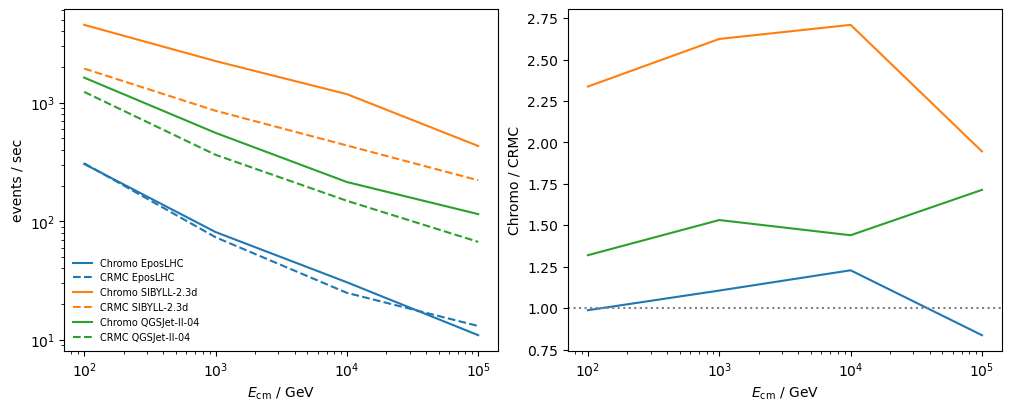

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4), constrained_layout=True)
for model, (times_chromo, times_crmc) in timing.items():
    plt.sca(ax[0])
    l = plt.plot(energies, times_chromo, label=f"Chromo {model}")[0]
    plt.plot(energies, times_crmc, label=f"CRMC {model}", color=l.get_color(), ls="--")
    plt.sca(ax[1])
    plt.plot(energies, np.divide(times_chromo, times_crmc), color=l.get_color())
plt.sca(ax[0])
plt.xlabel("$E_\\mathrm{cm}$ / GeV")
plt.ylabel("events / sec")
plt.loglog()
plt.legend(frameon=False, fontsize="x-small")
plt.sca(ax[1])
plt.axhline(1, ls=":", color="0.5")
plt.xlabel("$E_\\mathrm{cm}$ / GeV")
plt.ylabel("Chromo / CRMC")
plt.semilogx()
